<a href="https://colab.research.google.com/github/saritmaitra/Segmentation-Clustering/blob/master/MarketBasket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [30]:
pip install mlxtend  

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [33]:
data = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
# standardize the columns to lowercase
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
invoiceno      541909 non-null object
stockcode      541909 non-null object
description    540455 non-null object
quantity       541909 non-null int64
invoicedate    541909 non-null datetime64[ns]
unitprice      541909 non-null float64
customerid     406829 non-null float64
country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [67]:
# dimesion of the dataframe as well as unique invoiceno and customerid
print('Data dimension (row count, col count): {dim}'
     .format(dim= data.shape))
print('Count of unique invoice numvers: {cnt}'
     .format(cnt=data.invoiceno.nunique()))
print('Count of unique customer ids: {cnt}'
     .format(cnt=data.customerid.nunique()))

Data dimension (row count, col count): (532621, 8)
Count of unique invoice numvers: 22064
Count of unique customer ids: 4339


If we compare invoicno vis-a-vis description, we can see that some of the rows do not have invoice number. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [36]:
data['invoiceno'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
579777      687
581217      676
537434      675
580730      662
538071      652
580367      650
580115      645
581439      635
580983      629
578344      622
538349      620
578347      606
537638      601
537237      597
536876      593
576617      593
536592      592
537823      591
576837      585
579508      578
577078      572
537240      568
577358      561
576618      552
576840      544
           ... 
561271        1
C541201       1
561256        1
C554790       1
561255        1
543035        1
543034        1
561386        1
543018        1
561490        1
561489        1
561487        1
561486        1
561484        1
543014        1
561483        1
543016        1
543017        1
561482        1
561392        1
561481        1
561480        1
561479        1
561478        1
561477        1
561476        1
561475        1
C548464       1
C579186       1
558715        1
Name: invoiceno, Length:

In [37]:
data['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [39]:
data.dropna(axis=0, subset=['invoiceno'], inplace=True)
data['invoiceno'] = data['invoiceno'].astype('str')
data = data[~data['invoiceno'].str.contains('C')]
data.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

In [40]:
basket = (data[data['country'] =="Australia"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))

basket.head()

description,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,3 HOOK HANGER MAGIC GARDEN,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,4 TRADITIONAL SPINNING TOPS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS RUSTIC CHARM,60 CAKE CASES VINTAGE CHRISTMAS,70'S ALPHABET WALL ART,72 SWEETHEART FAIRY CAKE CASES,ABC TREASURE BOOK BOX,ADVENT CALENDAR GINGHAM SACK,ALARM CLOCK BAKELIKE CHOCOLATE,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE RED,ANIMALS AND NATURE WALL ART,APOTHECARY MEASURING JAR,ASSORTED BOTTLE TOP MAGNETS,ASSORTED COLOUR MINI CASES,ASSORTED COLOURS SILK FAN,ASSORTED EASTER GIFT TAGS,BAKING MOULD EASTER EGG MILK CHOC,BAKING MOULD EASTER EGG WHITE CHOC,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BELLE JARDINIERE CUSHION COVER,...,VINTAGE CHRISTMAS GIFT SACK,VINTAGE CHRISTMAS STOCKING,VINTAGE CHRISTMAS TABLECLOTH,VINTAGE DONKEY TAIL GAME,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KID DOLLY CARD,VINTAGE LEAF CHOPPING BOARD,VINTAGE PAISLEY STATIONERY SET,VINTAGE RED ENAMEL TRIM JUG,VINTAGE RED ENAMEL TRIM PLATE,VINTAGE RED TRIM ENAMEL BOWL,VINTAGE UNION JACK CUSHION COVER,VINTAGE UNION JACK MEMOBOARD,WALL ART CLASSIC PUDDINGS,WALL ART GARDEN HAVEN,WALL TIDY RETROSPOT,WHITE BELL HONEYCOMB PAPER,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HEART CONFETTI IN TUBE,WOODEN ADVENT CALENDAR CREAM,WOODLAND HEIGHT CHART STICKERS,WOODLAND BUNNIES LOLLY MAKERS,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP ALPHABET POSTER,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP VINTAGE LEAF DESIGN,WRAP WEDDING DAY,YELLOW GIANT GARDEN THERMOMETER
invoiceno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,6.0,48.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

In [61]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets

description,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,3 HOOK HANGER MAGIC GARDEN,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,4 TRADITIONAL SPINNING TOPS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS RUSTIC CHARM,60 CAKE CASES VINTAGE CHRISTMAS,70'S ALPHABET WALL ART,72 SWEETHEART FAIRY CAKE CASES,ABC TREASURE BOOK BOX,ADVENT CALENDAR GINGHAM SACK,ALARM CLOCK BAKELIKE CHOCOLATE,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE RED,ANIMALS AND NATURE WALL ART,APOTHECARY MEASURING JAR,ASSORTED BOTTLE TOP MAGNETS,ASSORTED COLOUR MINI CASES,ASSORTED COLOURS SILK FAN,ASSORTED EASTER GIFT TAGS,BAKING MOULD EASTER EGG MILK CHOC,BAKING MOULD EASTER EGG WHITE CHOC,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BELLE JARDINIERE CUSHION COVER,...,VINTAGE CHRISTMAS GIFT SACK,VINTAGE CHRISTMAS STOCKING,VINTAGE CHRISTMAS TABLECLOTH,VINTAGE DONKEY TAIL GAME,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KID DOLLY CARD,VINTAGE LEAF CHOPPING BOARD,VINTAGE PAISLEY STATIONERY SET,VINTAGE RED ENAMEL TRIM JUG,VINTAGE RED ENAMEL TRIM PLATE,VINTAGE RED TRIM ENAMEL BOWL,VINTAGE UNION JACK CUSHION COVER,VINTAGE UNION JACK MEMOBOARD,WALL ART CLASSIC PUDDINGS,WALL ART GARDEN HAVEN,WALL TIDY RETROSPOT,WHITE BELL HONEYCOMB PAPER,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HEART CONFETTI IN TUBE,WOODEN ADVENT CALENDAR CREAM,WOODLAND HEIGHT CHART STICKERS,WOODLAND BUNNIES LOLLY MAKERS,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP ALPHABET POSTER,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP VINTAGE LEAF DESIGN,WRAP WEDDING DAY,YELLOW GIANT GARDEN THERMOMETER
invoiceno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537676,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
539419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540267,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540700,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
541149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
541271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that I could get enough useful examples):

In [43]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# generate the rules with their corresponding support, confidence and lift
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
print (frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

      support                                           itemsets
0    0.070175                    (36 PENCILS TUBE RED RETROSPOT)
1    0.087719                      (4 TRADITIONAL SPINNING TOPS)
2    0.105263                       (ALARM CLOCK BAKELIKE GREEN)
3    0.070175                       (ALARM CLOCK BAKELIKE IVORY)
4    0.105263                        (ALARM CLOCK BAKELIKE RED )
5    0.122807                    (BAKING SET 9 PIECE RETROSPOT )
6    0.140351                       (BAKING SET SPACEBOY DESIGN)
7    0.087719                     (BLACK/BLUE POLKADOT UMBRELLA)
8    0.087719                      (BLUE HAPPY BIRTHDAY BUNTING)
9    0.087719                         (CIRCUS PARADE LUNCH BOX )
10   0.070175                    (CUSHION COVER PINK UNION JACK)
11   0.105263                             (DOLLY GIRL LUNCH BOX)
12   0.070175                            (DOORMAT RED RETROSPOT)
13   0.070175                   (DOORMAT SPOTTY HOME SWEET HOME)
14   0.105263            

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED RETROSPOT CAKE STAND),(36 PENCILS TUBE RED RETROSPOT),0.070175,0.070175,0.070175,1.000000,14.250000,0.065251,inf
1,(36 PENCILS TUBE RED RETROSPOT),(RED RETROSPOT CAKE STAND),0.070175,0.070175,0.070175,1.000000,14.250000,0.065251,inf
2,(36 PENCILS TUBE RED RETROSPOT),(SET OF 3 CAKE TINS PANTRY DESIGN ),0.070175,0.157895,0.070175,1.000000,6.333333,0.059095,inf
3,(SET OF 3 CAKE TINS PANTRY DESIGN ),(36 PENCILS TUBE RED RETROSPOT),0.157895,0.070175,0.070175,0.444444,6.333333,0.059095,1.673684
4,(4 TRADITIONAL SPINNING TOPS),(SET OF 6 SOLDIER SKITTLES),0.087719,0.122807,0.070175,0.800000,6.514286,0.059403,4.385965


In [69]:
print('Number of association" {}'. format(rules.shape[0]))

Number of association" 800


Text(0.5, 1.0, 'Confidence')

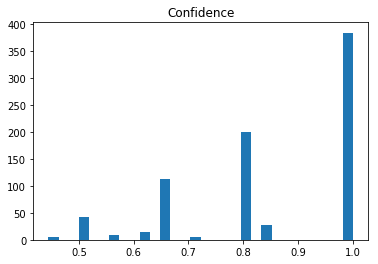

In [71]:
rules.hist('confidence', grid=False, bins = 30)
plt.title("Confidence")

Text(0.5, 1.0, 'Lift')

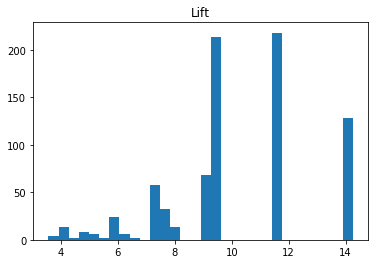

In [72]:
rules.hist('lift', grid=False, bins = 30)
plt.title("Lift")

### Confidence and Support in Data Mining
- To select interesting rules we can use best-known constraints which are a minimum thresholds on confidence and support.
- Support is an indication of how frequently the itemset appears in the dataset.
Confidence is an indication of how often the rule has been found to be true. [5]

In [44]:
support=rules.as_matrix(columns=['support'])
confidence=rules.as_matrix(columns=['confidence'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


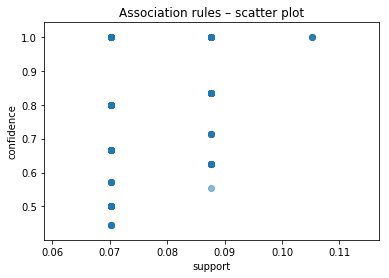

In [45]:
import random
import matplotlib.pyplot as plt

plt.scatter(support, confidence,   alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence') 
plt.title('Association rules – scatter plot')
plt.show()

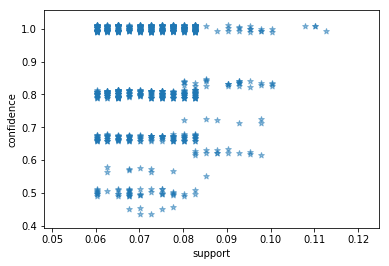

In [55]:
for i in range (len(support)):
   support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
   confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

Now, the tricky part is figuring out what this tells us. For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy. Since I do not have that, I’ll just look for a couple of illustrative examples.

We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (0.8):

In [0]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED RETROSPOT CAKE STAND),(36 PENCILS TUBE RED RETROSPOT),0.070175,0.070175,0.070175,1.000000,14.250000,0.065251,inf
1,(36 PENCILS TUBE RED RETROSPOT),(RED RETROSPOT CAKE STAND),0.070175,0.070175,0.070175,1.000000,14.250000,0.065251,inf
2,(36 PENCILS TUBE RED RETROSPOT),(SET OF 3 CAKE TINS PANTRY DESIGN ),0.070175,0.157895,0.070175,1.000000,6.333333,0.059095,inf
3,(4 TRADITIONAL SPINNING TOPS),(SET OF 6 SOLDIER SKITTLES),0.087719,0.122807,0.070175,0.800000,6.514286,0.059403,4.385965
4,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.105263,0.105263,0.105263,1.000000,9.500000,0.094183,inf
5,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.105263,0.105263,0.105263,1.000000,9.500000,0.094183,inf
6,(RED DINER WALL CLOCK),(ALARM CLOCK BAKELIKE GREEN),0.070175,0.105263,0.070175,1.000000,9.500000,0.062789,inf
7,(RED DINER WALL CLOCK),(ALARM CLOCK BAKELIKE RED ),0.070175,0.105263,0.070175,1.000000,9.500000,0.062789,inf
9,(REGENCY SUGAR BOWL GREEN),(BAKING SET 9 PIECE RETROSPOT ),0.070175,0.122807,0.070175,1.000000,8.142857,0.061557,inf
11,(RED RETROSPOT UMBRELLA),(BLACK/BLUE POLKADOT UMBRELLA),0.070175,0.087719,0.070175,1.000000,11.400000,0.064020,inf


In looking at the rules, it seems that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together in a manner that is higher than the overall probability would suggest.

At this point, we may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. 

In [50]:
basket['RED RETROSPOT CAKE STAND'].sum()

73.0

In [51]:
basket['36 PENCILS TUBE RED RETROSPOT'].sum()

385.0

We can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks so maybe we can drive more Red Alarm Clock sales through recommendations?

What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in Germany:

In [53]:
basket2 = (data[data['country'] =="France"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
print (frequent_itemsets2)

rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

      support                                           itemsets
0    0.071429                      (4 TRADITIONAL SPINNING TOPS)
1    0.096939                       (ALARM CLOCK BAKELIKE GREEN)
2    0.102041                        (ALARM CLOCK BAKELIKE PINK)
3    0.094388                        (ALARM CLOCK BAKELIKE RED )
4    0.068878                       (ASSORTED COLOUR MINI CASES)
5    0.081633                    (BAKING SET 9 PIECE RETROSPOT )
6    0.051020                           (BLUE HARMONICA IN BOX )
7    0.068878                      (CHARLOTTE BAG APPLES DESIGN)
8    0.066327                  (CHARLOTTE BAG DOLLY GIRL DESIGN)
9    0.058673                      (CHARLOTTE BAG PINK POLKADOT)
10   0.051020                     (CHILDREN'S APRON DOLLY GIRL )
11   0.066327                  (CHILDRENS APRON SPACEBOY DESIGN)
12   0.071429                    (CHILDRENS CUTLERY DOLLY GIRL )
13   0.068878                      (CHILDRENS CUTLERY SPACEBOY )
14   0.056122            

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
2,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
8,(CHILDRENS CUTLERY DOLLY GIRL ),(CHILDRENS CUTLERY SPACEBOY ),0.071429,0.068878,0.063776,0.892857,12.962963,0.058856,8.690476
9,(CHILDRENS CUTLERY SPACEBOY ),(CHILDRENS CUTLERY DOLLY GIRL ),0.068878,0.071429,0.063776,0.925926,12.962963,0.058856,12.535714
10,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.125000,0.099490,0.071429,0.571429,5.743590,0.058992,2.101190
11,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273


In [73]:
print('Number of association" {}'. format(rules2.shape[0]))

Number of association" 86


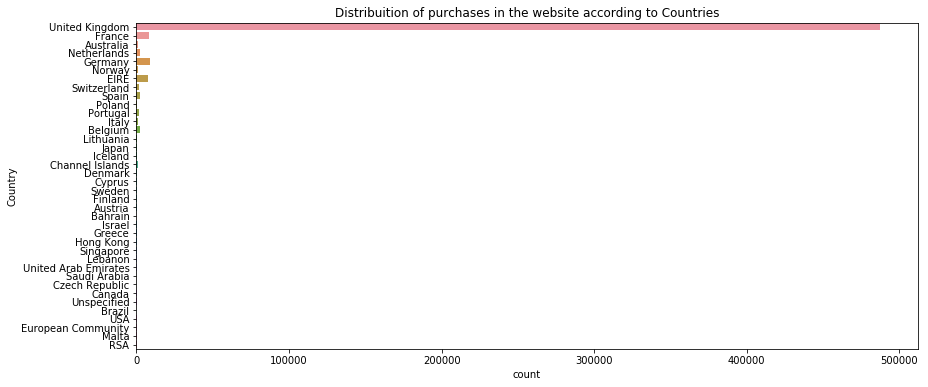

In [0]:
# Plotting InvoiceNo distribution per Country
plt.figure(figsize=(14,6))
plt.title('Distribuition of purchases in the website according to Countries');
sns.countplot(y='Country', data=df);